In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(17)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/Shareddrives/Deep Learning Project/Project/data

/content/drive/Shareddrives/Deep Learning Project/Project/data


In [7]:
sp = pd.read_csv("SPX_2.csv")
sp["Date"] = pd.to_datetime(sp['Date'])
sp = sp[['Date','Open','High','Low','Close']]
sp = sp.sort_values('Date', ascending=True)
start_date = pd.to_datetime('1980-01-01')
sp = sp[sp['Date'] >= start_date]
sp_df = sp[['Open','High','Low','Close']]

In [8]:
sp

,Date,Open,High,Low,Close
13022,1980-01-02,107.940002,108.430000,105.290001,105.760002
13023,1980-01-03,105.760002,106.080002,103.260002,105.220001
13024,1980-01-04,105.220001,107.080002,105.089996,106.519997
13025,1980-01-07,106.519997,107.800003,105.800003,106.809998
13026,1980-01-08,106.809998,109.290001,106.290001,108.949997
...,...,...,...,...,...
23318,2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107
23319,2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961
23320,2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990
23321,2020-11-03,3336.250000,3389.489990,3336.250000,3369.159912


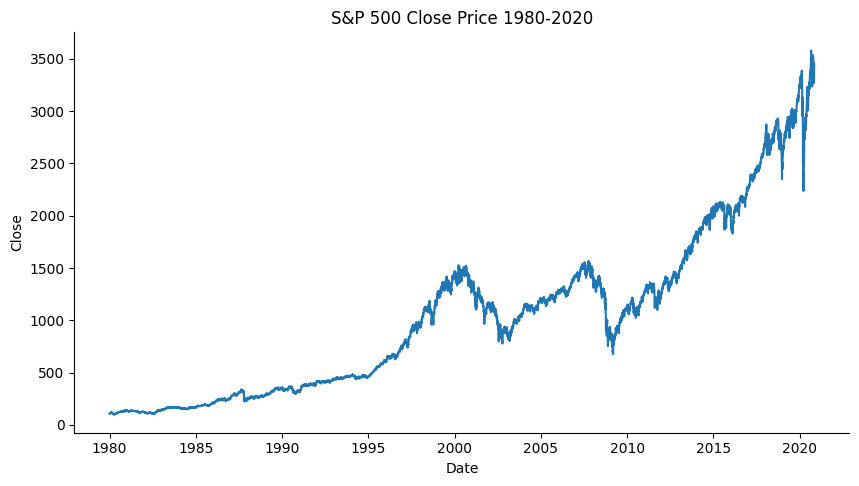

In [11]:
# @title Date vs Close

import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = sp.sort_values('Date')

plt.figure(figsize=(10, 5.2))
plt.plot(df_sorted['Date'], df_sorted['Close'], label='Close Price')

sns.despine()
plt.title("S&P 500 Close Price 1980-2020")
plt.xlabel('Date')
plt.ylabel('Close')

plt.show()


In [12]:
# Split data into train and test
train_size = int(len(sp) * 0.85)
train_df, test_df = sp.iloc[:train_size], sp.iloc[train_size:]

print(train_df.shape,test_df.shape)

(8755, 5) (1546, 5)


In [15]:
train = train_df.copy()
test = test_df.copy()

In [16]:
train_df = train_df[['Date','Close']]
test_df = test_df[['Date','Close']]

In [17]:
# Normalize the numerical data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

train_num_cols = train_df.columns.difference(['Date'])
test_num_cols = test_df.columns.difference(['Date'])

train_df[train_num_cols] = scaler.fit_transform(train_df[train_num_cols])
test_df[test_num_cols] = scaler.transform(test_df[test_num_cols])

In [18]:
train

,Date,Open,High,Low,Close
13022,1980-01-02,107.940002,108.430000,105.290001,105.760002
13023,1980-01-03,105.760002,106.080002,103.260002,105.220001
13024,1980-01-04,105.220001,107.080002,105.089996,106.519997
13025,1980-01-07,106.519997,107.800003,105.800003,106.809998
13026,1980-01-08,106.809998,109.290001,106.290001,108.949997
...,...,...,...,...,...
21772,2014-09-10,1988.410034,1996.660034,1982.989990,1995.689941
21773,2014-09-11,1992.849976,1997.650024,1985.930054,1997.449951
21774,2014-09-12,1996.739990,1996.739990,1980.260010,1985.540039
21775,2014-09-15,1986.040039,1987.180054,1978.479980,1984.130005


In [19]:
sequence_length = 10

# Prepare sequences of data for training
def create_sequences(data, dates, sequence_length):
    sequences = []
    targets = []
    sequence_dates= []
    # seq and targets the same
    for i in range(0, len(data) - sequence_length+1, sequence_length):
        sequences.append(data[i: i + sequence_length])
        targets.append(data[i: i + sequence_length])
        sequence_dates.append(dates[i + sequence_length - 1])
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

train_data = train_df[train_num_cols].values
test_data = test_df[test_num_cols].values
train_dates = train_df['Date'].values
test_dates = test_df['Date'].values

X_train, y_train, train_seq_dates = create_sequences(train_data, train_dates, sequence_length)
X_test, y_test, test_seq_dates = create_sequences(test_data, test_dates, sequence_length)

In [20]:
X_train.shape

(875, 10, 1)

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_autoencoder(input_shape):
    # Encoder
    inputs = keras.Input(shape=input_shape)
    encoder_lstm1 = layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoder_lstm2 = layers.LSTM(64, activation='relu', return_sequences=False, name='encode_out')(encoder_lstm1)

    # Latent representation
    repeat_vector = layers.RepeatVector(sequence_length,name='repeat_vec')(encoder_lstm2)

    # # Decoder1
    # decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    # attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm1, repeat_vector], return_attention_scores=True)
    # decoder_lstm2 = layers.LSTM(128, activation='relu', return_sequences=True)(attention_output)

    # decoder 2
    decoder_lstm1 = layers.LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    attention_output1 = layers.Attention()([decoder_lstm1, repeat_vector])
    decoder_lstm2 = layers.LSTM(128, activation='relu', return_sequences=True)(attention_output1)


    # attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm2, encoder_lstm1],return_attention_scores=True)
    # Output layer
    outputs = layers.TimeDistributed(layers.Dense(1), name='output_sequence')(decoder_lstm2)

    # Attention
    attention_output, attention_score = layers.Attention(name='attention_scores')([decoder_lstm2, encoder_lstm1],return_attention_scores=True)



    model = keras.Model(inputs=inputs, outputs=[outputs,attention_score,encoder_lstm2])
    # model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer='adam', loss={'output_sequence':'mse','attention_scores':None,'encode_out':None},
                  metrics={'output_sequence':'mse','attention_scores':None,'encode_out':None})

    return model


input_shape = (sequence_length, len(train_num_cols))
model = build_lstm_autoencoder(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 10, 128)              66560     ['input_1[0][0]']             
                                                                                                  
 encode_out (LSTM)           (None, 64)                   49408     ['lstm[0][0]']                
                                                                                                  
 repeat_vec (RepeatVector)   (None, 10, 64)               0         ['encode_out[0][0]']          
                                                                                              

In [22]:
history=model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, shuffle=False)


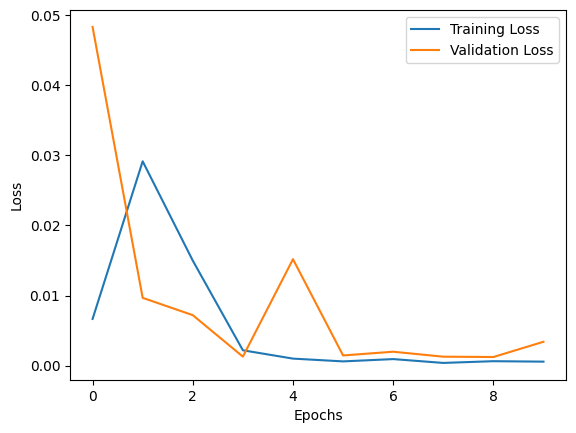

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.savefig('images/loss.png', dpi=900)
plt.legend();


In [16]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 13ms/step - loss: 0.1730 - output_sequence_loss: 0.1730 - output_sequence_mse: 0.1730


[0.17302531003952026, 0.17302531003952026, 0.17302529513835907]

In [ ]:
# test_seq_dates
model.save('saved_models/final_model_2_attentions')

In [23]:
def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
    plt.figure(figsize=(15, 7))
    actual_plot = actual[:, -1, feature_index]
    reconstructed_plot = reconstructed[:, -1, feature_index]
    plt.plot(dates, actual_plot, label='Actual', color='blue')
    plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
    plt.title(f'Reconstruction of {feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{feature_name} Values')
    plt.legend()
    plt.grid(True)
    plt.show()



reconstructions, scores, encode = model.predict(X_test)

plot_reconstruction_over_time(test_seq_dates, y_test, reconstructions, feature_index=0, feature_name='Close')

In [24]:
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
# print(len(X_test_inverse))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))
# print(len(reconstructions_inverse))
reconstruction_errors = np.mean(np.square(X_test_inverse - reconstructions_inverse),axis=1)
# print(reconstruction_errors)

# threshold
threshold = np.percentile(reconstruction_errors, 98.5)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies))

In [37]:
anomal = (np.where(anomalies)[0]/10).astype(int) # get the batch of the anomalies

5/5 [==============================] - 0s 12ms/step


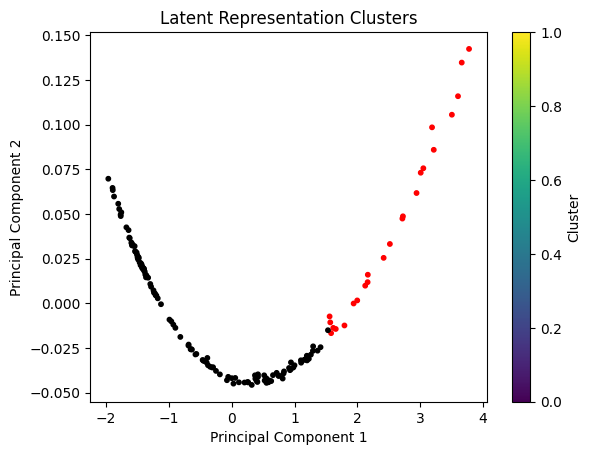

In [82]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

encoder_model = keras.Model(inputs=model.input, outputs=model.get_layer('encode_out').output)
latent_rep_train = encoder_model.predict(X_train)
latent_rep_test = encoder_model.predict(X_test)

pca = PCA(n_components=2)
latent_rep_pca = pca.fit_transform(latent_rep_test)

col = []
for i in range(0, len(latent_rep_pca)):
  if i in anomal:
    # print(i)
    col.append('red')
  else:
    col.append('black')

# Plot the clusters
plt.scatter(latent_rep_pca[:, 0], latent_rep_pca[:, 1], c=col, s=10)
plt.title('Latent Representation Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [20]:
# np.where(anomalies)

In [ ]:
# # reconstructions, scores = model.predict(X_test)
# reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1,2))

# # threshold
# threshold = np.percentile(reconstruction_errors, 95)

# # Identify anomalies in test
# anomalies = reconstruction_errors > threshold
# print("Detected anomalies:", np.where(anomalies)[0])

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, random_state=42)
latent_rep_tsne = tsne.fit_transform(latent_rep_test)
col =[]

for i in range(0, len(latent_rep_tsne)):
  if i in anomal:
    # print(i)
    col.append('red')
  else:
    col.append('black')


plt.scatter(latent_rep_tsne[:, 0], latent_rep_tsne[:, 1], c=col, s=10)
plt.title('Latent Representation Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.savefig('images/latent_rep_clusters.png',dpi=900)
plt.show()

In [ ]:
X_test_pred, attention_scores = model.predict(X_test)


5/5 [==============================] - 0s 14ms/step


In [92]:
X_test_inverse.shape[0]

1540

In [97]:
test

,index,Date,Open,High,Low,Close,Anomaly,Batch_ID
0,21777,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,0,0
1,21778,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,0,0
2,21779,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,0,0
3,21780,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,0,0
4,21781,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,0,0
...,...,...,...,...,...,...,...,...
1541,23318,2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,0,154
1542,23319,2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,0,154
1543,23320,2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,0,154
1544,23321,2020-11-03,3336.250000,3389.489990,3336.250000,3369.159912,0,154


In [26]:
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[2]))
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, reconstructions.shape[2]))

# fix shaping
X_test_inverse = X_test_inverse.reshape(X_test.shape)
reconstructions_inverse = reconstructions_inverse.reshape(reconstructions.shape)

def plot_reconstruction_over_time(dates, actual, reconstructed, feature_index, feature_name):
    plt.figure(figsize=(15, 7))
    actual_plot = actual[:, -1, feature_index]
    reconstructed_plot = reconstructed[:, -1, feature_index]
    plt.plot(dates, actual_plot, label='Actual', color='blue')
    plt.plot(dates, reconstructed_plot, label='Reconstructed', color='red', alpha=0.7)
    plt.title(f'Reconstruction of {feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{feature_name} Values')
    plt.legend()
    plt.grid(True)
    # plt.savefig('images/reconstruction_close_final.png', dpi=900)
    plt.show()

# reconstructions = model.predict(X_test)
plot_reconstruction_over_time(test_seq_dates, X_test_inverse, reconstructions_inverse, feature_index=0, feature_name='Close')

In [ ]:
# # Predict on train data
# reconstructions, scores = model.predict(X_test)
# reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1,2))

# # threshold
# threshold = np.percentile(reconstruction_errors, 95)

# # Identify anomalies in test
# anomalies = reconstruction_errors > threshold
# print("Detected anomalies:", np.where(anomalies)[0])

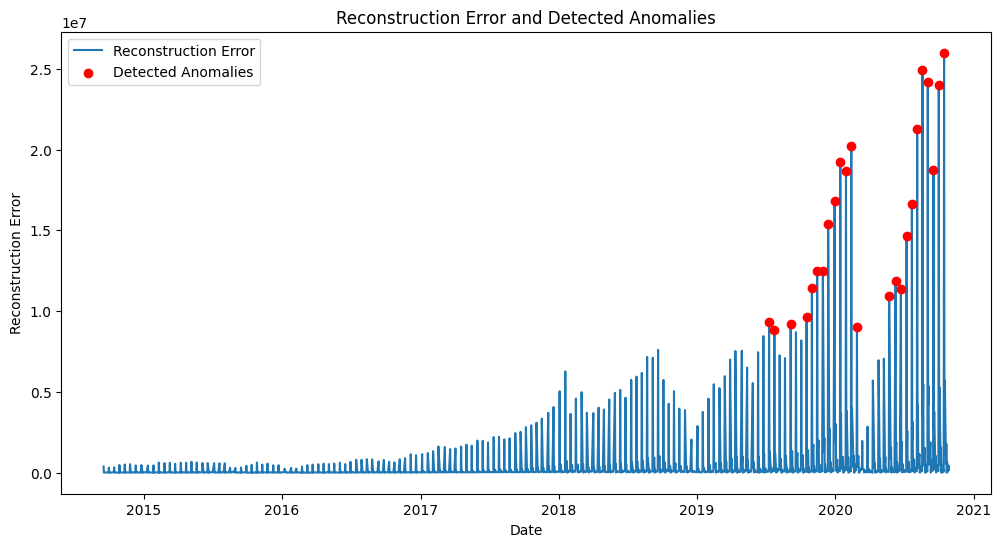

In [41]:
# plot recon errors against date
anomaly_indices = np.where(anomalies)
truncated_dates = test_df['Date'][:1540]

# reconstruction error over time
plt.figure(figsize=(12, 6))
plt.plot(truncated_dates, reconstruction_errors, label='Reconstruction Error')

#  detected anomalies
plt.scatter(truncated_dates.iloc[anomaly_indices], reconstruction_errors[anomaly_indices],
            color='red', label='Detected Anomalies', zorder=3)

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Detected Anomalies')
plt.legend()
# plt.savefig('images/recon_error.png',dpi=900)
plt.show()


5/5 [==============================] - 0s 15ms/step


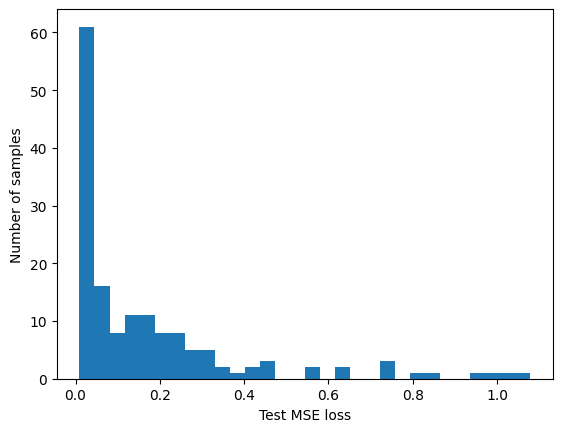

In [42]:
X_test_pred, attention_scores, encode = model.predict(X_test)
test_mse_loss = np.mean(np.square(X_test_pred-X_test), axis=1)

plt.hist(test_mse_loss, bins=30)
plt.xlabel('Test MSE loss')
plt.ylabel('Number of samples');


In [ ]:
# model.save('saved_models/final_model')

In [43]:
# get the dates of the anomalies
anomaly_indices = np.where(anomalies)
anomaly_dates = test_df['Date'].iloc[anomaly_indices]
print("Detected Anomalies Dates:")
print(anomaly_dates)


Detected Anomalies Dates:
22987   2019-07-10
22997   2019-07-24
23027   2019-09-05
23057   2019-10-17
23067   2019-10-31
23077   2019-11-14
23087   2019-11-29
23097   2019-12-13
23107   2019-12-30
23117   2020-01-14
23127   2020-01-29
23137   2020-02-12
23147   2020-02-27
23207   2020-05-22
23217   2020-06-08
23227   2020-06-22
23237   2020-07-07
23247   2020-07-21
23257   2020-08-04
23267   2020-08-18
23277   2020-09-01
23287   2020-09-16
23297   2020-09-30
23307   2020-10-14
Name: Date, dtype: datetime64[ns]


In [44]:
import pandas as pd
import numpy as np

test_df['Date'] = pd.to_datetime(test_df['Date'])
anomaly_dates = pd.to_datetime(anomaly_dates)

# anomaly flags
anomaly_flags = test_df['Date'].isin(anomaly_dates).astype(int)
test['Anomaly'] = anomaly_flags
print(test['Anomaly'])


21777    0
21778    0
21779    0
21780    0
21781    0
        ..
23318    0
23319    0
23320    0
23321    0
23322    0
Name: Anomaly, Length: 1546, dtype: int64


In [45]:
test = test.reset_index()
test['Batch_ID'] = test.index // 10

In [74]:
## Anonmalies seem to always be the forsst date of the window

In [75]:
test[test['Batch_ID'] == 149]

,index,Date,Open,High,Low,Close,Anomaly,Batch_ID
1490,23267,2020-08-18,3387.040039,3395.060059,3370.149902,3389.780029,1,149
1491,23268,2020-08-19,3392.510010,3399.540039,3369.659912,3374.850098,0,149
1492,23269,2020-08-20,3360.479980,3390.800049,3354.689941,3385.510010,0,149
1493,23270,2020-08-21,3386.010010,3399.959961,3379.310059,3397.159912,0,149
1494,23271,2020-08-24,3418.090088,3432.090088,3413.129883,3431.280029,0,149
1495,23272,2020-08-25,3435.949951,3444.209961,3425.840088,3443.620117,0,149
1496,23273,2020-08-26,3449.969971,3481.070068,3444.149902,3478.729980,0,149
1497,23274,2020-08-27,3485.139893,3501.379883,3468.350098,3484.550049,0,149
1498,23275,2020-08-28,3494.689941,3509.229980,3484.320068,3508.010010,0,149
1499,23276,2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,0,149


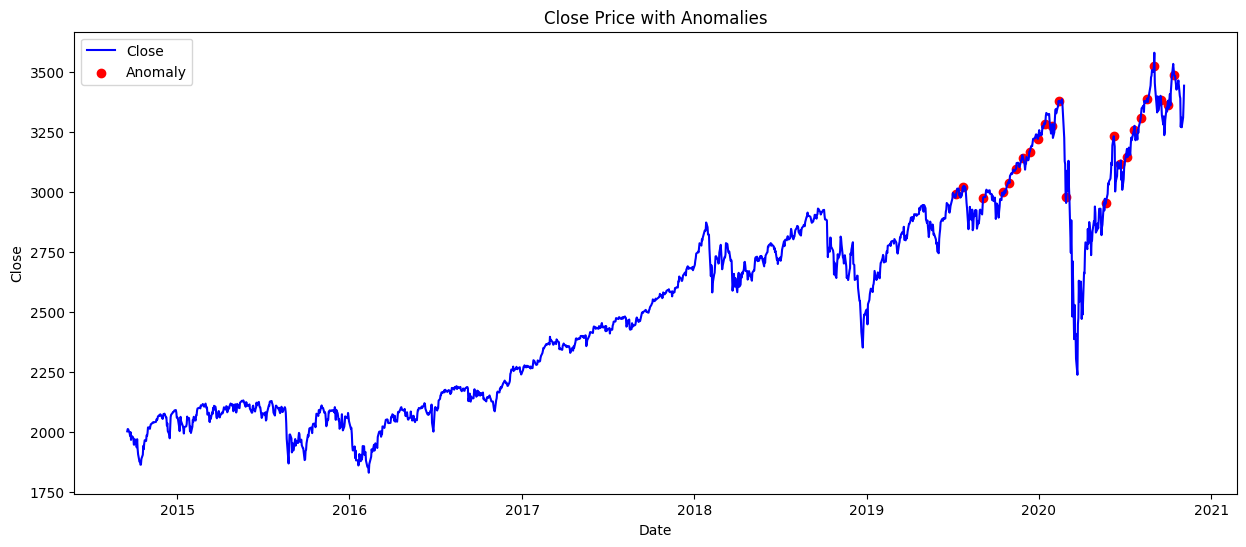

In [47]:
df = test
df['Date'] = pd.to_datetime(df['Date'])
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')

# Plot the anomalies (where Anomaly == 1) as red points
anomalies = df[df['Anomaly'] == 1]
plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomaly')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close Price with Anomalies')
plt.legend()
# plt.savefig('images/Anomalies_detected_in_test.png', dpi=900)
# Show the plot
plt.show()

In [1]:
# Predict on train data
reconstructions, scores , encode= model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1,2))

# threshold
threshold = np.percentile(reconstruction_errors, 98.5)

# Identify anomalies in test
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.where(anomalies)[0])

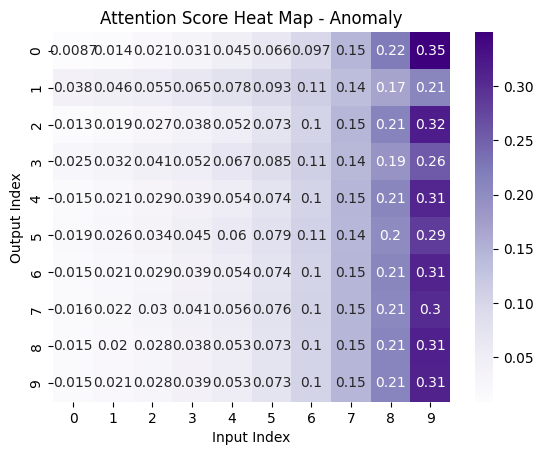

In [69]:
sns.heatmap(scores[149], cmap='Purples', annot=True)

plt.title('Attention Score Heat Map - Anomaly')
plt.xlabel('Input Index')
plt.ylabel('Output Index')
# plt.savefig('anon_window.png', dpi = 900)

plt.show()

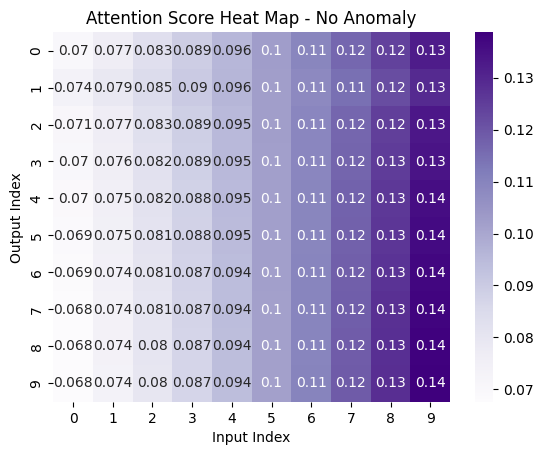

In [66]:
sns.heatmap(scores[10], cmap='Purples', annot=True)

plt.title('Attention Score Heat Map - No Anomaly')
plt.xlabel('Input Index')
plt.ylabel('Output Index')
plt.savefig('non_anon_window.png', dpi = 900)

plt.show()

In [108]:
import numpy as np
from scipy.special import rel_entr  # Relative entropy function for KL Divergence

prob1 = scores[153]
prob1 /= prob1.sum()

prob2 = scores[149]
prob2 /= prob2.sum()

# Calculate KL Divergence
kl_divergence = np.sum(rel_entr(prob1, prob2))
print(f"KL Divergence: {kl_divergence}")

KL Divergence: 7.899686170276254e-05
